**This notebook is pytorch implementation for [Convolutional Neural Networks for Sentence Classification][id].compared to original paper we do some**

### **Requirement**<br>
```bash
-OSLinux-Ubuntu18.04.05  
-Data set:IMDB dataset
```
### **Data information**<br>  
-Train example nums: 17500  
-Val example nums:7500  
-test example nums:25000  
-Taget class nums:2  

[id]:https://arxiv.org/abs/1408.5882


##**Build Data and preprocess**
####In this part,we do something below:  
1.build spacy tokenizer and toknize raw text  
2.split data set to train set and val set  
3.set vocab size(contain \<unk>,<pad> special token) and collect word in train set  
4.download GLoVe pretrained Word Embedding(6B.100d) and build for our vocabulary  
5.build data loader for train,val,test data and set init Bs(64)  

In [1]:
import torch
from torch.nn import functional as F
from torch import nn,optim
from torch.optim.lr_scheduler import ExponentialLR,StepLR,MultiStepLR,LambdaLR,MultiplicativeLR,ReduceLROnPlateau
from torchtext import data,datasets

from sklearn import  metrics
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.svm import SVC

import random
import numpy as np
import spacy
import os
import time
SEED=1234


#set random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True
device=torch.device('cuda:0')

#build Field and tokenizer
spacy.require_gpu()
en_nlp=spacy.load('en_core_web_sm')
def en_tokenizer(text):
  """this func will be tokenized raw text by using spacy model"""
  return [t.text for t in en_nlp.tokenizer(text) if t.text.isalpha()]
Text=data.Field(tokenize=en_tokenizer,lower=True,batch_first=True)
Target=data.Field(is_target=True,batch_first=True,pad_token=None,unk_token=None)
VOCAB_size=25001#set vocabuary size

#load data
train_data,test_data=datasets.IMDB.splits(Text,Target)
train_data,val_data=train_data.split(split_ratio=0.7,random_state=random.seed(SEED))
print('One examples:{} from IMDB'.format(train_data.examples[0]))

#build text Embedding vector
Text.build_vocab(train_data,vectors='glove.6B.100d',max_size=VOCAB_size)
Text.vocab.set_vectors(Text.vocab.stoi,Text.vocab.vectors,dim=100)

#build Target vocab
Target.build_vocab(train_data)

#build data loader
Batch_size=50
train_iter,val_iter,test_iter=data.BucketIterator.splits((train_data,val_data,test_data),batch_size=Batch_size,device=device)

aclImdb_v1.tar.gz:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:03<00:00, 22.0MB/s]


One examples:<torchtext.data.example.Example object at 0x7f63ff1363c8> from IMDB


.vector_cache/glove.6B.zip: 862MB [06:28, 2.22MB/s]                           
100%|█████████▉| 399603/400000 [00:30<00:00, 12399.65it/s]

In [2]:
print('Train num:',len(train_data))
print('Val num:',len(val_data))
print('test num:',len(test_data))

Train num: 17500
Val num: 7500
test num: 25000


##**Stage2:Design Model structure**
####We build three type DL model.You can use help or .__doc__ to look model Architecture detail.

Three type model:  
1.Conv2D  
2.Cnn1D-LSTM  
3.Conv2D+Traditional ML  

And We will use init Model & data setting to evaluate three type model performance.

In [3]:
class ConvNets_2d(nn.Module):
  '''
  Class ConvNets_2d is a Neural network based on Convolution Layer.
  It's inherit from pytorch nn.Module class.So some class method is
  common.


  Architecture:
    1.Embedding_layer:This layer has three mode.One is using init Embed,
     another is using GLoVe pretrained Embed,the other is hybrid of
     GLoVe and init Embed.
    2.Convolution_layer:The three different type filter height is setting to 
     filter_size.And the filter width is fixed based on Embed dim.
     After filter,We choose ReLU for activations.For pooling strategy,
     we choose MaxPooling1D for each feature map.Finally,we concatenate
     Each feature into a single vector that genertaioned by pooling.
     
    3.Fully_connected_layer:
     This layer is output_layer.So it's shape will be 
     [n_filter*filter_size,output_dim].And it output is Logitics.


  Args:
    1.input_dim(int):This argument is used for setting Embedding input dim.
    2.embed_dim(int):This argument is used for setting Embedding dim.
    3.output_dim(int):This argument is used for whole netowrk output dim.
    4.n_filters(int):This argument is used for setting channel's num in each
     filter
    5.filter_size(list of int):This argument is set for different filter height.
     and use list to contain three filter height.
     e.g.[3,4,5].one filter'width will set three,another will set four.The other
           will set five.
    6.dropout_rate(float):This argument is used for setting final cocnated layer's
     dropout rate.
    7.pad_idx(int):This argument is used for setting index which Embed vector's is zero.
    8.pretrained_embed(torch tensor):This argument is used for loading pretrained Embedding 
     weight.Note that embed's vector nums is consistent with input_dim.
     if you don't set any torch tensor type embedding weight,it will use init random 
     Embedding layer.Default is None.
    9.is_mulc(boolean):This arguemnt is determined Whther is using Multi channel for Embed_layer.
  '''
  def __init__(self,input_dim,embed_dim,output_dim,n_filters,filter_size,
        dropout_rate,pad_idx=None,pretrained_embed=None,is_mulc=False):
    super(ConvNets_2d,self).__init__()

    #determined filter_size type and length
    assert isinstance(filter_size,tuple) and len(filter_size)==3,\
    'filter_size is not list type or len=3'
    #dteremined pretrained embed dtype and create
    if pretrained_embed is not None:
      assert isinstance(pretrained_embed,torch.tensor) and (pretrained_embed.shape[0]==input_dim),\
      "The pretrained Embed isn't a torch tensor type or nums don't equal to input_dim"

      self.is_pretrained=True
      if is_mulc:
        self.embed=nn.Embedding(input_dim,embed_dim,padding_idx=pad_idx)
        self.preEmbed=nn.Embedding.from_pretrained(pretrained_embed)
      else:
        self.preEmbed=nn.Embedding.from_pretrained(pretrained_embed)
    else:
      self.is_pretrained=False
      self.embed=nn.Embedding(input_dim,embed_dim,padding_idx=pad_idx)

    #set network main attr.
    self.input_dim=input_dim
    self.embed_dim=embed_dim
    self.output_dim=output_dim
    self.is_mulc=is_mulc
    self.inp_channels=2 if is_mulc else 1
    #create each filter height
    self.conv1=nn.Conv2d(self.inp_channels,n_filters,kernel_size=(filter_size[0],embed_dim))
    self.conv2=nn.Conv2d(self.inp_channels,n_filters,kernel_size=(filter_size[1],embed_dim))
    self.conv3=nn.Conv2d(self.inp_channels,n_filters,kernel_size=(filter_size[2],embed_dim))
    #build fc_layer
    self.fc_layer=nn.Linear(n_filters*len(filter_size),output_dim)

    self.ReLU=nn.ReLU()
    self.dropout=nn.Dropout(dropout_rate)

  def forward(self,input_tensors,using_ml=False):
    #determined whether to use multichannel Embedding or not.
    if self.is_mulc and self.is_pretrained:
      embed_output=self.embed(input_tensors).unsqueeze(1)
      pre_embed_output=self.preEmbed(input_tensors).unsqueeze(1)
      #embed_output=[bs,2,seqlen,embed_dim]
      embed_output=torch.cat((embed_output,pre_embed_output),dim=1)
    else:
      #embed_output=[bs,1,seqlen,embed_dim]
      embed_output=self.embed(input_tensors).unsqueeze(1)
    
    #feature_map=[bs,n_filters,map_len]
    fm_1=self.ReLU(self.conv1(embed_output).squeeze(3))
    fm_2=self.ReLU(self.conv2(embed_output).squeeze(3))
    fm_3=self.ReLU(self.conv3(embed_output).squeeze(3))

    #pooled=[bs,n_filters]
    pooled_1=F.max_pool1d(fm_1,fm_1.shape[2]).squeeze(2)
    pooled_2=F.max_pool1d(fm_2,fm_2.shape[2]).squeeze(2)
    pooled_3=F.max_pool1d(fm_3,fm_3.shape[2]).squeeze(2)

    #concat pooled=[bs,n_filters*3]
    cat_pool=torch.cat((pooled_1,pooled_2,pooled_3),dim=1)

    if using_ml:
      return cat_pool
    else:
      return self.fc_layer(cat_pool)

In [5]:
class Conv1d_LSTM(nn.Module):
  '''
  Class Conv1d_LSTM is a Neural network based on hybrid of Convolution Layer and LSTM_layer.
  It's inherit from pytorch nn.Module class.So some class method is common.
  

  Architecture:
    1.Embedding_layer:this layer is init random Embedding.
    2.One dimension Convolution Layer:In contrast to general Convolution filter,
    it's has single directional moving and only one dimension.and We apply it for 
    seqLen's direction to capture different time's related Info.After that,each feature
    map will be view as new embedding vector's one dimension.
    #If you want to understand how does it work,please read
    3.RNN layer:I use lstm for rnn_layer,and In Rnn output part,we will use
    Mean pooling strategy to combine information.
    4.fc and output layer:
  

  Args:
    1.input_embed(int):This argument is used for setting input dim(vocab's num).
    2.embed_dim(int):This argument is used for setting Embedding dim.
    3.output_hid(int):This argument is used for setting lstm hidden output_dim.
    4.output_dim(int):This argument is used for whole netowrk output_dim.
    5.n_filters(int):This argument is used for setting filter's num.
    6.filter_size(int):This argument is used for setting filter's length.
    7.n_layers(int):This argument is used for setting lstm layer_nums.
    8.pad_idx(int):This argument is used for setting index which Embed vector's is zero.
    9.dropout_rate(float):This argument is used for setting final cocnated layer's
     dropout rate.
    10.is_bidirectional(boolean):This argument is used for setting to use bidirectional lstm
     or not.
  '''
  def __init__(self,input_embed,embed_dim,output_hid,output_dim,n_filters,
        filter_size,n_layers,pad_idx,dropout_rate=0.1,is_bidirectional=False):
    super(Conv1d_LSTM,self).__init__()
    #model attr.
    self.input_embed=input_embed
    self.embed_dim=embed_dim
    self.pad_idx=pad_idx
    self.output_dim=output_dim
    
    #build layer
    self.embedd_layer=nn.Embedding(input_embed,embed_dim,padding_idx=pad_idx)
    self.conv1d_embed=nn.Conv1d(embed_dim,n_filters,kernel_size=filter_size)
    self.rnn_layer=nn.LSTM(n_filters,output_hid,n_layers,batch_first=True,dropout=dropout_rate,bidirectional=is_bidirectional)
    self.fc_layer=nn.Linear(output_hid,int(output_hid/2))
    self.output_layer=nn.Linear(int(output_hid/2),output_dim)


    #build activFunc.
    self.tanh=nn.Tanh()
    self.ReLU=nn.ReLU()
    self.dropout_layer=nn.Dropout(dropout_rate)
  def forward(self,input_tensors):

    #tensor shape=[Bs,seqlen,embed_dim]
    embed_tensors=self.embedd_layer(input_tensors)
    #transpose and convert tensor from shape=[Bs,embed_dim,seqLen] into shape=[Bs,filter_num,pooled_seqLen]
    #In conv1d_layer,Each length(filter size) filter extract feature from embed_tensor to produce one feature map.
    #And we can view one feature map as one dim of embedding vector.So how many feature map,it's will be embedding dim.
    feature_maps=self.conv1d_embed(embed_tensors.transpose(1,2))

    #After Cnn Layer.we should transpose tensor to shape=[Bs,pooled_seqLen,filter_num]
    feature_maps=self.ReLU(feature_maps.transpose(1,2))

    #shape=[Bs,seqLen,output_hid]
    output_tensors,_=self.rnn_layer(feature_maps)

    #shape=[Bs,seqLen,output_hid/2]
    output_tensors=self.fc_layer(torch.mean(output_tensors,dim=1))
    
    #return logisitcs
    return self.output_layer(self.dropout_layer(self.ReLU(output_tensors)))

In [30]:
#build Random Forest Model
class HybridDL_model:
  '''
  Class HybridDL_model is combine Deep Learning Model and Traditional Model.
  You can use Deep Learning Model to extract data feature, and then pass this 
  feature to ML_model to predict. 
  In other word,your DL model is pretrained Model,you only fine-tuning your ml model
  params to predict.


  Architecture:
   1.DL_model:your trained DL model
   2.ML_model:your ml_model.
  

  Args:
   1.ML_model(sklearn Model class):sklearn Model class.
   2.DL_model(torch.Module object):torch.nn.module object
   3.ml_kwargs(dict):This arg is set for your ml_model.Note that because using incremental learning.So your args should set incremental
   4.device(torch.device):torch device object.
  '''
  def __init__(self,ML_model,DL_model,ml_kwargs,device):
    #build Model
    self.ml_model=ML_model(**ml_kwargs)
    self.DL_model=DL_model
    assert isinstance(self.DL_model,nn.Module),'This object is not torch.nn'
    self.ml_kwargs=ml_kwargs
    self.device=device
  def online_train(self,input_iters):
    #extract feature using dl_model

    self.DL_model.eval()
    with torch.no_grad():
      for bs in input_iters:
        if next(self.DL_model.parameters()).is_cuda:
          input_texts=bs.text.to(self.device)
          labels=bs.label.to(self.device).squeeze(dim=1)
        else:
          input_texts=bs.text
          labels=bs.label.squeeze(dim=1)
        #x_logitics shape=[bs,feature_dim]
        x_logitics=self.DL_model(input_texts,using_ml=True)
        #convert to numpy array
        x_logitics=x_logitics.cpu().clone().numpy()
        #online training ML_model
        self.ml_model.fit(x_logitics,labels.cpu().clone().numpy())
      
      #evaluate hybrid Model
      acc=self.evaluate_model(train_iter)
      print(f'Hybrid Model Training Accuracy:{acc}')
  def evaluate_model(self,val_iter):
    total_accuracy=0
    total_Fscore=0
    self.DL_model.eval()
    with torch.no_grad():
      for bs in val_iter:
        if next(self.DL_model.parameters()).is_cuda:
          input_texts=bs.text.to(self.device)
          labels=bs.label.to(self.device).squeeze(dim=1)
        else:
          input_texts=bs.text
          labels=bs.label.squeeze(dim=1)
        #x_logitics shape=[bs,feature_dim]
        x_logitics=self.DL_model(input_texts,using_ml=True)
        #convert to numpy array
        x_logitics=x_logitics.cpu().clone().numpy()
        labels=labels.cpu().clone().numpy()
        #online training ML_model
        accuracy=self.ml_model.score(x_logitics,labels)
        predicts=self.ml_model.predict(x_logitics)
        total_accuracy+=accuracy
        total_Fscore+=metrics.f1_score(labels,predicts)
    
    return total_accuracy/len(val_iter),total_Fscore/len(val_iter)
  def predict(self,input_tensors):
    x_logitics=self.DL_model(input_tensors,using_ml=True)
    x_logitics=x_logitics.cpu().clone().detach().numpy()

    #model_predict
    predicts=self.ml_model.predict(x_logitics)
    return predicts

In [25]:
def getModelPredict(outputs):
  """
  It's will convert model logitics output to binary output(1 or 0).
  And we using segmoid func. and threshold>=0.5 to convert,this func.
  return will be numpy dtype object.
  """
  preds=torch.where(torch.sigmoid(outputs)>=0.5,1,0).squeeze(dim=1).cpu().detach().numpy()
  return preds
def getBClassEvaluate(pred_label,true_label):
  """
  This func will using accuracy and F-score to evaluate model performance.
  Return is accuracy,f_score
  """
  accuracy=metrics.accuracy_score(true_label,pred_label)
  f_score=metrics.f1_score(true_label,pred_label)
  return accuracy,f_score
def EvaluateModel(model,data_iter,loss_fn):
  """
  This function is evaluate Model pipeline.


  Parameters:
   model(torch.Module):The model that you want to train.Note that if you want to 
              use GPU for training,you should put it in GPU before pass to
              This arg.
   val_iter(torch.DataLoader):This data_iterator that you want to evaluate Model.
   criterion(torch.nn):This argument is your model loss_func.


  Return:
   model_valMetrics(dict):It's will contain val_loss,accuracy,F_score.
  """
  total_loss=0
  total_accuracy=0
  total_F=0
  model.eval()
  with torch.no_grad():
    for bs in data_iter:
      input_texts=bs.text
      labels=bs.label

      #using autocast
      if torch.cuda.is_available():
        #output_logitics=[bs,num_labels]
        output_logitics=model(input_texts)
        loss=loss_fn(output_logitics,labels.float())
      
      total_loss+=loss.item()
      preds=getModelPredict(output_logitics)
      acc,f_score=getBClassEvaluate(preds,labels.cpu().detach().numpy())

      total_accuracy+=acc
      total_F+=f_score
  
  return {'loss':total_loss/len(data_iter),
      'Accuracy':total_accuracy/len(data_iter),
      'F_score':total_F/len(data_iter)}
def count_parameters(model):
  """It's will count total params num for model."""
  return sum(p.numel()for p in model.parameters() if p.requires_grad)
def trainModel(model,train_iter,optimizer,criterion,device):
  """
  This function is training Model pipeline.


  Parameters:
   model(torch.Module):The model that you want to train.Note that if you want to 
              use GPU for training,you should put it in GPU before pass to
              This arg.
   train_iter(torch.DataLoader):This argument is pytorch DataLoader object.
   optimzier(torch.optim):This argument is pytorch optimizer object,and Before passing to argument,
              ir should contain model params. 
   criterion(torch.nn):This argument is your model loss_func.
   device(torch.cuda):This argument is your model device location.


  Return:
   epoch_trainLoss(float):List contains model training loss in one epochs.
  """

  train_loss=0
  model.train()
  for bs in train_iter:
    if next(model.parameters()).is_cuda:
      input_texts=bs.text.to(device)
      labels=bs.label.to(device)
    else:
      input_texts=bs.text
      labels=bs.label
    
    #using autocast to choose appropriate datatype for each layer.
    output_logitics=model(input_texts)
    loss=criterion(output_logitics,labels.float())#compute loss
    train_loss+=loss.item()
    
    #scaled loss.And using backpropagation to compute scaled Gradient of corrspending dtype in forward pass stage.
    #This operation can avoid FP16 datatype can not present close zero problem
    loss.backward()

    #Fist step is unscaled gradient of optimizer assigned params.
    #if gradient value don't conatin NaN and inf,it will call optimizer.step()
    #other wise will skip optimizer.step()
    optimizer.step()
    optimizer.zero_grad()

  return train_loss/len(train_iter)

In [8]:
#Record Start training time
def epoch_trainModel(model,train_iter,val_iter,optimizer,criterion,n_epochs,device,scheduler=None,batch_size=None):
  """
  This function is training Model pipeline that on epochs level.
  So You can custom design your training pipeline.And this pipeline
  will compute your model generilzation using val_iter

  Parameters:
   model(torch.Module):The model that you want to train.Note that if you want to 
              use GPU for training,you should put it in GPU before pass to
              This arg.
   train_iter(torch.DataLoader):This argument is pytorch DataLoader object.
   val_iter(torch.DataLoader):This argument is same as train_iter.
   optimzier(torch.optim):This argument is pytorch optimizer object,and Before passing to argument,
              ir should contain model params. 
   criterion(torch.nn):This argument is your model loss_func.
   n_epochs(int):This argument is how many training model iterations.
   device(torch.cuda):This argument is your model device location.
   schedular(torch.optim object):This argument is used to set model learning_rate schedule.If you set 
                   None,training won't use schedule to train model.Default is None.
   batch_size(int):This argument will modified train_iter Batchsize.Default is None.
  
  Return:
   epoch_trainLoss(list of float):List contains model training loss in each epochs.
   epcohs_vaLoss(list of float):List contains model val loss in each epochs.
  """
  total_time=0
  epoch_trainLoss=[]
  epoch_vaLoss=[]
  
  #modified Batch_size
  if batch_size is not None:
    train_iter.batch_size=batch_size
    val_iter.batch_size=Batch_size
  print(f'Current data Batch_size is {train_iter.batch_size}')
  for ep in range(n_epochs):
    #training Model
    start_time=time.time()
    train_loss=trainModel(model,train_iter,optimizer,criterion,device)
    end_time=time.time()

    #vaildate Model performance
    train_metrics=EvaluateModel(model,train_iter,criterion)
    eval_metrics=EvaluateModel(model,val_iter,criterion)

    #update learning rate
    if scheduler is not None:
      if isinstance(scheduler,ReduceLROnPlateau):
        scheduler.step(eval_metrics['loss'])
      else:
        print(f'{ep+1} epochs lr:{scheduler.get_lr()}\n')
        scheduler.step()
        
    #append train & val loss
    epoch_trainLoss.append(train_loss)
    epoch_vaLoss.append(eval_metrics['loss'])

    #display Model info.
    print(f'[{ep+1}/{N_epochs}] train_loss:{train_loss}')
    for key,v in train_metrics.items():
      if key!='loss':
        print(f'train {key}:{v}')
    for key,v in eval_metrics.items():
      print(f'eval {key}:{v}')
    total_time+=(end_time-start_time)
    print(f'Training time:{end_time-start_time}s \n')
  print(f'Total trainng time:{total_time}s')

  return epoch_trainLoss,epoch_vaLoss

##Compared different Model performance
We set params to compare model performance.

####Common
```bash
Input_dim=25001
Embed_dim=100
output_dim=1
pad_idx='<pad>' in vicab index
n_epochs=13
```

####For conv2d
```bash
filters_num=100
dropout_rate=0.5
3 type kernel size filter=(3,4,5)
```
####For cnn-lstm
```bash
filters_num=256
hidden(lstm)_output=128
hidden_layers=2
dropout_rate=0.1
1 type kernel size filter=3
```
####For hybrid(cnn,ml)
```bash
1.DL_model=conv2d
2.ml_model=RandomForest
3.Rf_params={'n_estimators':145,'max_depth':5,'n_jobs':-1,'warm_start':True}
```


###**Model performance compared**
|       | Train loss |val loss| test loss| 
| ----- | ------     | ---    | ---------|
| Conv2d | 84e-4 | 0.4249 | 893  |0.417|
| Cnn-Lstm|0.013 | 1.993 | 700  | 2.235|
| Hybrid| - | - |- | 

|       | Train acc|val acc| test acc|train F-score| val F-score| test F-score|
| ----- | ------ | --- | ---- | ------------- | ----------- |------|
| Conv2d| 1.0   | 0.873 | 0.872| 1.0      | 0.876    |0.803|
|Cnn-Lstm|0.998 |0.845  | 0.827| 0.998    | 0.851   |0.762|
| Hybrid| 0.948 |0.797  | 0.799| 0.945      | 0.779  |0.704|

In [27]:
Input_dim=len(Text.vocab)
Embed_dim=100
Output_dim=1
n_filters=100
pad_idx=Text.vocab.stoi['<pad>']
filter_size=(3,4,5)
dropout_rate=0.5
N_epochs=13

# #build Conv2d network
conv2d_model=ConvNets_2d(Input_dim,Embed_dim,Output_dim,n_filters,filter_size,dropout_rate,pad_idx=pad_idx)
conv2d_model.to(device)
cnn_optim=optim.Adam(conv2d_model.parameters())
criterion=nn.BCEWithLogitsLoss()
print('CovNets model scheme:{}'.format(conv2d_model))
print(f'Model trainable parameters num:{count_parameters(conv2d_model)}')

CovNets model scheme:ConvNets_2d(
  (embed): Embedding(25003, 100, padding_idx=1)
  (conv1): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
  (conv2): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
  (conv3): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  (fc_layer): Linear(in_features=300, out_features=1, bias=True)
  (ReLU): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)
Model trainable parameters num:2620901


In [28]:
#Training model for original Batch size(50)
orig_trainLoss,orig_valLoss=epoch_trainModel(conv2d_model,train_iter,val_iter,cnn_optim,criterion,N_epochs,device)

Current data Batch_size is 50
[1/13] train_loss:0.49577336839267183
train Accuracy:0.8923999999999991
train F_score:0.8843495800998931
eval loss:0.39303860247135164
eval Accuracy:0.827333333333333
eval F_score:0.8170388569378016
Training time:18.37659502029419s 

[2/13] train_loss:0.2770844340324402
train Accuracy:0.9491428571428558
train F_score:0.9500491955732226
eval loss:0.35735527326663336
eval Accuracy:0.8407999999999999
eval F_score:0.8541065544594646
Training time:17.84250497817993s 

[3/13] train_loss:0.15207492370690617
train Accuracy:0.9932571428571428
train F_score:0.9929534753293985
eval loss:0.3312628468374411
eval Accuracy:0.8594666666666668
eval F_score:0.8537025381411828
Training time:17.54124903678894s 

[4/13] train_loss:0.06326710520046099
train Accuracy:0.9998857142857143
train F_score:0.9998920295390883
eval loss:0.328247871696949
eval Accuracy:0.8694666666666666
eval F_score:0.867914048156624
Training time:17.78659200668335s 

[5/13] train_loss:0.0237766152034912

In [18]:
#build Cnn-lstm Model
Lstm_n_filters=256
output_hid=256
Lstm_filter_size=3
n_layers=2
cnnLstm_model=Conv1d_LSTM(Input_dim,Embed_dim,output_hid,Output_dim,Lstm_n_filters,Lstm_filter_size,n_layers,pad_idx)
cnnLstm_model.to(device)
Lstm_optim=optim.Adam(cnnLstm_model.parameters())
print('cnn-lstm model scheme:{}'.format(cnnLstm_model))
print(f'Model trainable parameters num:{count_parameters(cnnLstm_model)}')

cnn-lstm model scheme:Conv1d_LSTM(
  (embedd_layer): Embedding(25003, 100, padding_idx=1)
  (conv1d_embed): Conv1d(100, 256, kernel_size=(3,), stride=(1,))
  (rnn_layer): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.1)
  (fc_layer): Linear(in_features=256, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
  (tanh): Tanh()
  (ReLU): ReLU()
  (dropout_layer): Dropout(p=0.1, inplace=False)
)
Model trainable parameters num:3663053


In [19]:
#trainng Cnn1D_lstm
lstm_trainLoss,lstm_valLoss=epoch_trainModel(cnnLstm_model,train_iter,val_iter,Lstm_optim,criterion,N_epochs,device)

Current data Batch_size is 50
[1/13] train_loss:0.5738083870070321
train Accuracy:0.8399999999999999
train F_score:0.8281934017786555
eval loss:0.5057510277628898
eval Accuracy:0.7969333333333329
eval F_score:0.7790076808226845
Training time:61.33027505874634s 

[2/13] train_loss:0.3646996553029333
train Accuracy:0.9078285714285702
train F_score:0.9043731504739453
eval loss:0.4741052646934986
eval Accuracy:0.8419999999999997
eval F_score:0.8465736765923643
Training time:60.752609968185425s 

[3/13] train_loss:0.25421159484556743
train Accuracy:0.9140571428571412
train F_score:0.9168063575417784
eval loss:0.4337367640187343
eval Accuracy:0.8434666666666666
eval F_score:0.8550667152852724
Training time:60.53767442703247s 

[4/13] train_loss:0.17950324196368456
train Accuracy:0.9652571428571419
train F_score:0.9638961789993051
eval loss:0.5239754966894785
eval Accuracy:0.8602666666666668
eval F_score:0.8605057585839543
Training time:60.130383253097534s 

[5/13] train_loss:0.13227420695126

In [31]:
#build Random forest and CNN2d hybrid Model
Rf_params={'n_estimators':145,'max_depth':5,'n_jobs':-1,'warm_start':True}
RF_cnn2d=HybridDL_model(RandomForestClassifier,conv2d_model,Rf_params,device)

#training Model
RF_cnn2d.online_train(train_iter)
print(f'val_accuracy:{RF_cnn2d.evaluate_model(val_iter)}')
print(f'test accuracy:{RF_cnn2d.evaluate_model(test_iter)}')

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:359: UserWarn

Hybrid Model Training Accuracy:(0.9482857142857134, 0.9457134731454485)
val_accuracy:(0.7973333333333333, 0.779076481072143)
test accuracy:(0.7900799999999991, 0.704791555270396)


In [33]:
#compared model performance using test data
conv2d_metrics=EvaluateModel(conv2d_model,test_iter,criterion)
print('Conv2d model performance:{}'.format(conv2d_metrics))
cnnLstm_metrics=EvaluateModel(cnnLstm_model,test_iter,criterion)
print('Cnn-Lstm model performance:{}'.format(cnnLstm_metrics))
RF_cnn2dAcc,RF_cnn2dFscore=RF_cnn2d.evaluate_model(test_iter)
print('hybrid model accuracy:{} \t f_score:{}'.format(RF_cnn2dAcc,RF_cnn2dFscore))

Conv2d model performance:{'loss': 0.41719932660460474, 'Accuracy': 0.8722399999999983, 'F_score': 0.8038665762967696}
Cnn-Lstm model performance:{'loss': 2.235527881860733, 'Accuracy': 0.8279599999999995, 'F_score': 0.7628582513383452}
hybrid model accuracy:0.7900799999999991 	 f_score:0.704791555270396


# **Inference stage**
In inference stage,we can use trained model to predict input sentences sentiment.<br>
**Note**:if we input sentence length less than filter window size.model will be not work.So we set min_length argument.if sent_length<min_len,we pad sent that length equal to min_length argument.

In [34]:
def predict_sentiment(model,input_sents,Field,min_length):
  """
  This function is use to predict input_sents sentiment by
  using trained model.

  Parameters:
   model(torch.Module):The model that you want to train.Note that if you want to 
              use GPU for training,you should put it in GPU before pass to
              this arg.
   input_sents(str or list of token):You want to predict sentences.Note that the str should be Unicode.
   Field(torchtext.field):This Field object will convert sent's tokens to numerical. 
   min_length(int):set sentence minimize length.If your len(input_sents) lower than min_length.
                   It will pad sents length as same as min_length. 
  
  Return:
   Positive or Negative sentiment(int)
  """
  if isinstance(input_sents,str):
    input_tokens=[t.text.lower() for t in en_nlp.tokenizer(input_sents) if t.text.isalpha()]
  else:
    input_tokens=[t.lower() for t in input_sents if t.isalpha()]
  
  #pad_tokens
  if len(input_tokens)<min_length:
    input_tokens+=['<pad>']*(min_length-len(input_tokens))
  
  #convert to tensor
  input_tensor=Field.numericalize([input_tokens])

  if isinstance(model,nn.Module):
    if next(model.parameters()).is_cuda:
      input_tensor=input_tensor.cuda()
      output_logitics=model(input_tensor)
      predict=getModelPredict(output_logitics)
    return predict[0]
  else:
    if next(model.DL_model.parameters()).is_cuda:
      input_tensor=input_tensor.cuda()

      return model.predict(input_tensor)
  

In [41]:
test_example=test_data.examples[0]
test_sent=test_example.text
sentiment_score=predict_sentiment(conv2d_model,test_sent,Text,5)
hybrid_sentiment=predict_sentiment(RF_cnn2d,test_sent,Text,5)
print('-'*10+'Model predict'+'-'*10)
print(f"Test_text:{' '.join(test_sent)}\n sentiment:{Target.vocab.itos[sentiment_score]}")
print(f'True label:{test_example.label}')
print('-'*10+'Hybrid Model predict'+'-'*10)
print(f"sentiment:{Target.vocab.itos[hybrid_sentiment[0]]}")

----------Model predict----------
Test_text:the precise text of an ad except the word chinese as in grauman chinese at the end should appear in caps but imdb racially sensitive formatting wo let it as published in the los angeles times of october reads as follows with denoting the break between each line in the world premiere tonight promptly tonight all hollywood and los angeles boulevards become the big trail to grauman chinese theatre the rendezvous of all that is beautiful and brilliant the gathering place of stars celebrities the great and the will fill every seat many thousands will line hollywood boulevard to watch the gala festivities attending this world all southern california pays homage to the great american epic which faithfully depicts the thrilling soul stirring romance of the american pioneers who won the west and left us a heritage of peace liberty and walsh the big trail story by hal evarts fox movietone production shown entirely in grandeur cast of featuring john way

#**Extra expirement**
We use other hyperparameter Strategy for experiment Model performance.<br>
&nbsp;

####It's contain:<br>
 1.MiniBatch Size(128,256,512,1024)<br>
 2.Learning Rate and Learning Rate schedule<br>
 3.different type optimizer(SGD,RMSprop,Adgrad,Adam)<br>
 4.Warm-up and linear scaling rule

In [42]:
#display model loss time trend
import matplotlib.pyplot as plt
from math import ceil
# def autoLabel(line_2ds,ax):
#   xy_data=line_2ds[0].get_xydata()
#   for idx in range(xy_data.shape[0]):
#     ax.annotate(
#         '{:.3f}'.format(xy_data[idx,1]),xy=(xy_data[idx,0],xy_data[idx,1]),
#         xytext=(0,4),textcoords='offset points',ha='center',va='bottom')
  
def plot_Loss(times,times_loss,markers,colors,labels,titles):
  """
  This function is used to display model loss on different type condition in datas.

  Parameters:
   times(list of int):This arg is set for plot x_tick and labels.
   times_loss(lists of list of different type loss):This first dim of arg represents each data.The second dim will 
                                                    represent each condition over data,and third's will represent loss
                                                    at each times in condition.
   markers(list of marker):This arg set marker for each data.
   colors(list fo color):This arg set condition's color for each data.
   labels(list of str):This arg set condition's name  for each data.
   titles(list of str):This arg set title for each data.
  """


  rows=ceil(len(time_loss[0])/1)
  fig=plt.figure(figsize=(10,8))
  

  #plot lines
  for idx in range(0,rows):
    ax=fig.add_subplot(rows,1,idx+1)
    for tl,m,c,l in zip(times_loss,markers,colors,labels):
      line2ds=ax.plot(times,tl[idx],color=c,label=l,marker=m,ms=1.3)

      ax.set_xticks(times)
      ax.set_xticklabels(times)
      ax.set_xlabel('Epochs')
      ax.set_ylabel('Loss')
      ax.set_title(titles[idx])
      ax.legend()
  fig.tight_layout()
  plt.show()

###**First Experiment is test that whether different Learning Rate has  different influence on model performance.**
  After runing Model,we discover  
  >When Training BS increase,val loss will decrease and train loss will higher than lower Bs.

This result is the same as past research discovered.
The reason is when increase Bs will improve model generalization,but it update model weight times will decrease.So if it has the same Epoch nums condition,Model will convergence slower than small Batch size.



In [43]:

#training model with different Batch_size
optim_loss={}
Bs_params={'Bs_128':128,'Bs_256':256,'Bs_512':512,'Bs_1024':1024}
for names in Bs_params.keys():
  model=ConvNets_2d(Input_dim,Embed_dim,Output_dim,n_filters,filter_size,dropout_rate,pad_idx=Text.vocab.stoi['<pad>'])
  model.to(device)
  optimizer=optim.Adam(model.parameters())
  train_loss,val_loss=epoch_trainModel(model,train_iter,val_iter,optimizer,criterion,N_epochs,device,batch_size=Bs_params[names])
  optim_loss[names]=(train_loss,val_loss)
optim_loss['Bs_50']=(orig_trainLoss,orig_valLoss)

Current data Batch_size is 128
[1/13] train_loss:0.5535060702449214
train Accuracy:0.8522740796572517
train F_score:0.8462458496645294
eval loss:0.44939270079135896
eval Accuracy:0.8005333333333328
eval F_score:0.7950206207668378
Training time:15.819344282150269s 

[2/13] train_loss:0.34910889959683383
train Accuracy:0.9281155783878134
train F_score:0.9276828244985814
eval loss:0.3688048995534579
eval Accuracy:0.8383999999999997
eval F_score:0.8405856062091868
Training time:15.793871402740479s 

[3/13] train_loss:0.2373039035031395
train Accuracy:0.9714103657569026
train F_score:0.9707938560028698
eval loss:0.3413224857052167
eval Accuracy:0.8498666666666667
eval F_score:0.8469788877584018
Training time:15.819127082824707s 

[4/13] train_loss:0.14769992678269853
train Accuracy:0.993419747699143
train F_score:0.9933077270082744
eval loss:0.3233327716588974
eval Accuracy:0.8612000000000001
eval F_score:0.8645679604370684
Training time:15.819176435470581s 

[5/13] train_loss:0.08611784443

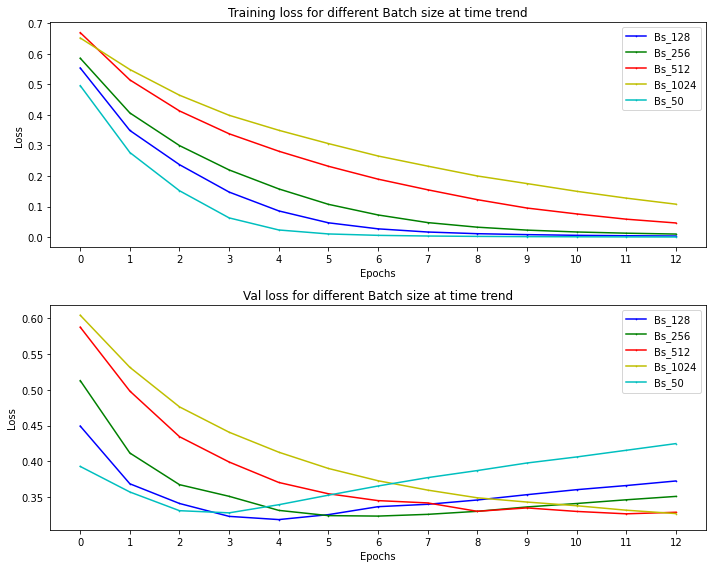

In [44]:
x_times=range(0,N_epochs)
titles=['Training loss for different Batch size at time trend','Val loss for different Batch size at time trend']

labels=list(optim_loss.keys())
time_loss=list(optim_loss.values())
colors=['b','g','r','y','c']
markers=['.']*len(time_loss)
plot_Loss(x_times,time_loss,markers,colors,labels,titles)

###**Second Experiment is test that whether different apative LR method has  different influence on model performance.**
 Before training,we set some condition:  
1.Data Btach size=256  
2.Model lr=1e-2  
  
  
####*Result has show Adagrad is the best suitable for this Model and Dataset.*

In [45]:
#training model with different optimizer,and we set 1e-2 for each optimizer learning rate.
Batch_size=256
optim_loss={}
optim_params={'SGD':optim.SGD,'RMSprop':optim.RMSprop,'Adagrad':optim.Adagrad,'Adam':optim.Adam}
for names in optim_params.keys():
  model=ConvNets_2d(Input_dim,Embed_dim,Output_dim,n_filters,filter_size,dropout_rate,pad_idx=Text.vocab.stoi['<pad>'])
  model.to(device)
  optimizer=optim_params[names](model.parameters(),lr=1e-2)
  train_loss,val_loss=epoch_trainModel(model,train_iter,val_iter,optimizer,criterion,N_epochs,device,batch_size=Batch_size)
  optim_loss[names]=(train_loss,val_loss)

Current data Batch_size is 256
[1/13] train_loss:0.7064028978347778
train Accuracy:0.4962438957151859
train F_score:0.6626368782669917
eval loss:0.7211607237656911
eval Accuracy:0.5099712171052632
eval F_score:0.6745571274142232
Training time:15.454985857009888s 

[2/13] train_loss:0.695523214512977
train Accuracy:0.5822872361373662
train F_score:0.5995879493602835
eval loss:0.6828763782978058
eval Accuracy:0.5717379385964912
eval F_score:0.5882944333044798
Training time:15.663268327713013s 

[3/13] train_loss:0.6939020087753517
train Accuracy:0.507408829552615
train F_score:0.023753918504366922
eval loss:0.7021544794241588
eval Accuracy:0.49575794956140345
eval F_score:0.024689986185703353
Training time:15.621111869812012s 

[4/13] train_loss:0.696847178797791
train Accuracy:0.5362441910838059
train F_score:0.6742777578230851
eval loss:0.6789430101712545
eval Accuracy:0.5446066337719297
eval F_score:0.6834813988016815
Training time:15.339267015457153s 

[5/13] train_loss:0.67985985849

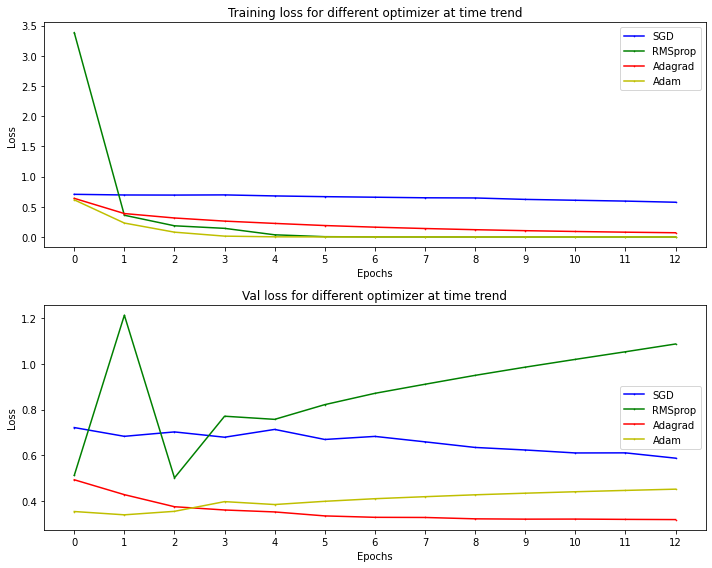

In [46]:
#plot training and val
labels=list(optim_loss.keys())
time_loss=list(optim_loss.values())
colors=['b','g','r','y']
titles=['Training loss for different optimizer at time trend','Val loss for different optimizer at time trend']
markers=['.']*len(time_loss)
plot_Loss(x_times,time_loss,markers,colors,labels,titles)

###**Third Experiment is test that whether different LR  has  different influence on model performance.**
 Before training,we set some condition:  
1.Data Btach size=256  
2.Model lr=1e-2  
3.optimizer=Adagrad
  
  
####*Result has show lr(1e-2)  is the best suitable for this Model and Dataset.*

In [47]:
#training model with different learning rate.
Batch_size=256
optim_loss={}
lr_params={'lr_1e-1':1e-1,'lr_1e-2':1e-2,'lr_1e-3':1e-3,'lr_1e-4':1e-4,'lr_1e-5':1e-5}

for names in lr_params.keys():
  #build Model
  model=ConvNets_2d(Input_dim,Embed_dim,Output_dim,n_filters,filter_size,dropout_rate,pad_idx=Text.vocab.stoi['<pad>'])
  model.to(device)
  optimizer=optim.Adam(model.parameters(),lr=lr_params[names])

  #collect Model info
  train_loss,val_loss=epoch_trainModel(model,train_iter,val_iter,optimizer,criterion,N_epochs,device,batch_size=Batch_size)
  optim_loss[names]=(train_loss,val_loss)



Current data Batch_size is 256
[1/13] train_loss:5.052391628424327
train Accuracy:0.5566123188405797
train F_score:0.34908209623394393
eval loss:0.934978969891866
eval Accuracy:0.4987801535087719
eval F_score:0.2626414336329445
Training time:15.64682412147522s 

[2/13] train_loss:1.0710988511209902
train Accuracy:0.70663988657845
train F_score:0.7363859001764025
eval loss:1.1664380570252737
eval Accuracy:0.6237047697368421
eval F_score:0.6601007897535976
Training time:15.701977491378784s 

[3/13] train_loss:1.2873808197353198
train Accuracy:0.704606765910523
train F_score:0.6936655760711249
eval loss:1.427865602572759
eval Accuracy:0.6002398574561403
eval F_score:0.5863056885820072
Training time:15.742129564285278s 

[4/13] train_loss:1.7876308931820635
train Accuracy:0.7029231647763076
train F_score:0.7488251021070664
eval loss:3.0868095636367796
eval Accuracy:0.618345668859649
eval F_score:0.6907757541665567
Training time:15.624083042144775s 

[5/13] train_loss:2.821384473123412
trai

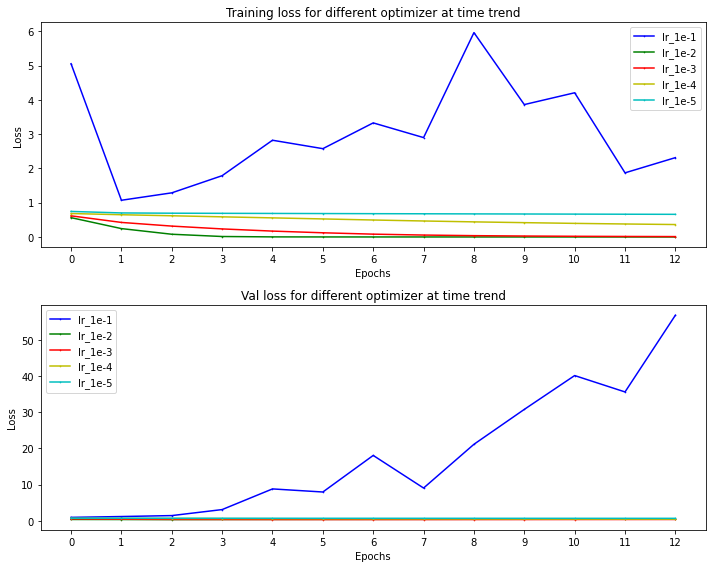

In [48]:
#plot training and val
labels=list(optim_loss.keys())
time_loss=list(optim_loss.values())
colors=['b','g','r','y','c']
markers=['.']*len(time_loss)
plot_Loss(x_times,time_loss,markers,colors,labels,titles)

###**Fourth Experiment is test that whether different LR_scheduler  has  different influence on model performance.**
 Before training,we set some condition:  
1.Data Btach size=256  
2.init lr=0.75  
3.optimizer=momentum SGD  
  
####And Result discover something interesting.Compared to original using SGD,*when we use SGD with lr_scheduler strategy to training,it will be worked.*

In [49]:
#using different type learning Rate scheduler to train Model
#define linear decay func
linear_lambda=lambda epoch:(N_epochs-epoch)/N_epochs
Batch_size=256
optim_loss={}
lr_params={'exp_decay':(ExponentialLR,{'gamma':0.85}),'step_deacy(3)':(StepLR,{'step_size':3,'gamma':0.5}),'Linear_Decay':(LambdaLR,{'lr_lambda':linear_lambda}),
      'Muti_step':(MultiStepLR,{'milestones':[3,5]+list(range(7,9))}),'ReduceLOP':(ReduceLROnPlateau,{'mode':'min','factor':0.5,'patience':4})}

for names in lr_params.keys():
  #build Model
  model=ConvNets_2d(Input_dim,Embed_dim,Output_dim,n_filters,filter_size,
           dropout_rate,pad_idx=Text.vocab.stoi['<pad>'])
  model.to(device)
  optimizer=optim.SGD(model.parameters(),lr=75e-3,momentum=0.9,dampening=5e-1)
  scheduler=lr_params[names][0](optimizer,**lr_params[names][1])

  #collect Model info
  train_loss,val_loss=epoch_trainModel(model,train_iter,val_iter,optimizer,criterion,
                    N_epochs,device,scheduler=scheduler,batch_size=Batch_size)
  optim_loss[names]=(train_loss,val_loss)

Current data Batch_size is 256


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:449: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


1 epochs lr:[0.075]

[1/13] train_loss:1.8414609613625899
train Accuracy:0.724017407057341
train F_score:0.7572256730369915
eval loss:0.5801426688830058
eval Accuracy:0.692859100877193
eval F_score:0.7356055764501018
Training time:15.652505874633789s 

2 epochs lr:[0.0541875]

[2/13] train_loss:0.4810872868351314
train Accuracy:0.8086331324826718
train F_score:0.8337522994729916
eval loss:0.4905993411938349
eval Accuracy:0.7609649122807017
eval F_score:0.799862939004683
Training time:15.449033260345459s 

3 epochs lr:[0.046059375]

[3/13] train_loss:0.3245083059089771
train Accuracy:0.929697345620668
train F_score:0.9327154925585228
eval loss:0.40845448871453605
eval Accuracy:0.8157003837719298
eval F_score:0.8346852921210914
Training time:15.468619585037231s 

4 epochs lr:[0.03915046875]

[4/13] train_loss:0.1973049387983654
train Accuracy:0.9890172101449275
train F_score:0.9889396008206659
eval loss:0.37716285487016044
eval Accuracy:0.8303179824561403
eval F_score:0.8377122411349234


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


1 epochs lr:[0.075]

[1/13] train_loss:1.8482865302459053
train Accuracy:0.6969714870825457
train F_score:0.7370996200445092
eval loss:0.5899841825167338
eval Accuracy:0.6727590460526316
eval F_score:0.724521048313613
Training time:15.526928901672363s 

2 epochs lr:[0.075]

[2/13] train_loss:0.46424518331237463
train Accuracy:0.8875457821361059
train F_score:0.8919217965008769
eval loss:0.4052744487921397
eval Accuracy:0.8152617872807018
eval F_score:0.8300711422229986
Training time:15.469133138656616s 

3 epochs lr:[0.075]

[3/13] train_loss:0.2856208915295808
train Accuracy:0.9684152488972906
train F_score:0.9684855765541835
eval loss:0.3609098662932714
eval Accuracy:0.8390556469298246
eval F_score:0.845707771141788
Training time:15.528300762176514s 

4 epochs lr:[0.01875]

[4/13] train_loss:0.1433940607568492
train Accuracy:0.993942481884058
train F_score:0.9938411697906189
eval loss:0.3625881314277649
eval Accuracy:0.8373492324561403
eval F_score:0.8371333206941475
Training time:15

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


1 epochs lr:[0.075]

[1/13] train_loss:1.2423248303973156
train Accuracy:0.6404083963453056
train F_score:0.44560986825670507
eval loss:0.6742583533128103
eval Accuracy:0.603453947368421
eval F_score:0.3766250940804649
Training time:15.325456380844116s 

2 epochs lr:[0.06923076923076923]

[2/13] train_loss:0.49742126378460205
train Accuracy:0.8750787649653434
train F_score:0.8617401785017069
eval loss:0.44490299820899964
eval Accuracy:0.7883771929824561
eval F_score:0.7642260802371955
Training time:15.559563159942627s 

3 epochs lr:[0.06346153846153846]

[3/13] train_loss:0.26248693509378296
train Accuracy:0.9717061476055451
train F_score:0.9708057678557033
eval loss:0.3851344386736552
eval Accuracy:0.8251096491228069
eval F_score:0.8161857208816105
Training time:15.39499568939209s 

4 epochs lr:[0.057692307692307696]

[4/13] train_loss:0.1333588546384936
train Accuracy:0.9839910207939508
train F_score:0.9836460258620496
eval loss:0.4455617904663086
eval Accuracy:0.809436677631579
eval

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:417: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


1 epochs lr:[0.075]

[1/13] train_loss:1.8163299785144087
train Accuracy:0.6458751772211719
train F_score:0.7183472787937365
eval loss:0.6713888883590698
eval Accuracy:0.6399259868421052
eval F_score:0.7194437345172565
Training time:15.460200309753418s 

2 epochs lr:[0.075]

[2/13] train_loss:0.48070175233094586
train Accuracy:0.8984276543793321
train F_score:0.8973968717509302
eval loss:0.4082996666431427
eval Accuracy:0.8141584429824562
eval F_score:0.816523149455523
Training time:15.367836952209473s 

3 epochs lr:[0.075]

[3/13] train_loss:0.2928881910832032
train Accuracy:0.9615405442659105
train F_score:0.9603573959540055
eval loss:0.37892770767211914
eval Accuracy:0.8287417763157895
eval F_score:0.8226385467895778
Training time:15.27459716796875s 

4 epochs lr:[0.00075]

[4/13] train_loss:0.14972624161105225
train Accuracy:0.9775249094202898
train F_score:0.9769643041419982
eval loss:0.3639823108911514
eval Accuracy:0.8363418311403509
eval F_score:0.8369399381345018
Training time

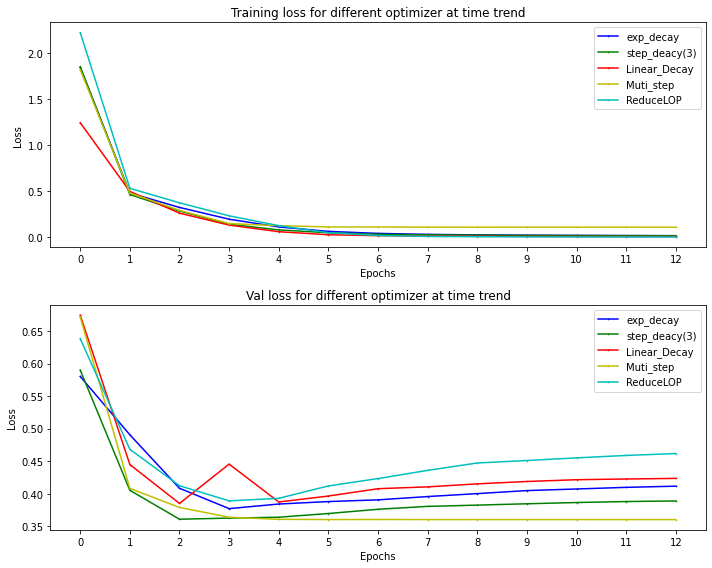

In [50]:
#plot training and val
labels=list(optim_loss.keys())
time_loss=list(optim_loss.values())
colors=['b','g','r','y','c']
markers=['.']*len(time_loss)
plot_Loss(x_times,time_loss,markers,colors,labels,titles)

##代研究事項  
1.使用character-level Cnn
2.採用Warm up schedule Method
